In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#PCA
from sklearn.decomposition import PCA
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
#Xmeans
from pyclustering.cluster import xmeans
#Optics
from sklearn.cluster import OPTICS

In [3]:
df=pd.read_csv("ravdess_features.csv")

In [4]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])

In [5]:
df["vocal_channel_fill"]=df["vocal_channel"]
df["vocal_channel_fill"]=df["vocal_channel_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["intensity_fill"]=df["intensity"]
df["intensity_fill"]=df["intensity_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [6]:
dfcopy1=df.copy()
df = df.drop(["emotion", "intensity_fill", "mfcc_min", "stft_mean", "min", "max", "sample_width", "frame_rate", "stft_max", "modality", "intensity", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max", "vocal_channel_fill", "frame_count"], axis=1)
df2 = df.drop(columns=["length_ms", "std", "sc_skew", "mfcc_mean", "sc_mean", "sc_std"])

In [7]:
X = df.values
X1 = df2.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
X_minmax1 = scaler.fit_transform(X1)

In [25]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_minmax)
principal3dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])

principal_components1 = pca.fit_transform(X_minmax1)
principal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])

# X-means

In [8]:
xm = xmeans.xmeans(X_minmax)
xm1 = xmeans.xmeans(X_minmax1)
xm.process()
xm1.process()

In [9]:
clusters = xm.get_clusters()
clusters1 = xm1.get_clusters()

In [10]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int) #np.empty crea nuovo array non inizializzato
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [11]:
Xlabels = clusters_to_labels(clusters)
Xlabels1 = clusters_to_labels(clusters1)

In [20]:
np.unique(Xlabels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [21]:
np.unique(Xlabels1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [30]:
print('silhouette', silhouette_score(X_minmax, Xlabels))
print('silhouette', silhouette_score(X_minmax1, Xlabels1))

silhouette 0.12330996386446857
silhouette 0.11860202707570539


### Xmeans PCA analysis

In [26]:
principal3dDf["xlabels"]=Xlabels
principal3dDf1["xlabels"]=Xlabels1

<Figure size 720x720 with 0 Axes>

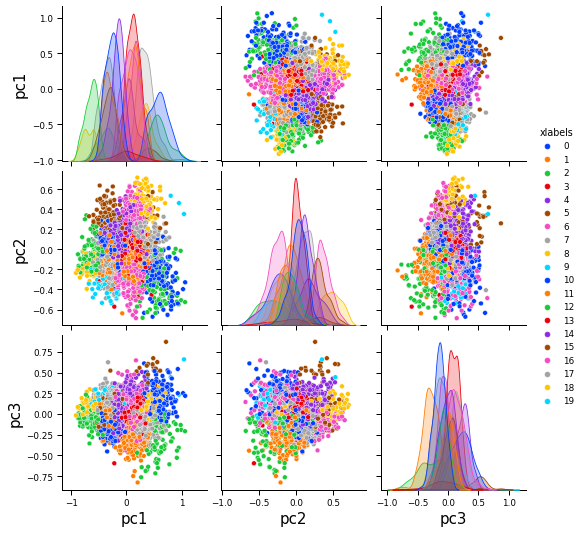

In [27]:
sns.set_context("paper", rc={"axes.labelsize":15, "legend":10})
plt.figure(figsize=(10,10))
sns.pairplot(data=principal3dDf, hue="xlabels", palette="bright")
plt.show()

<Figure size 720x720 with 0 Axes>

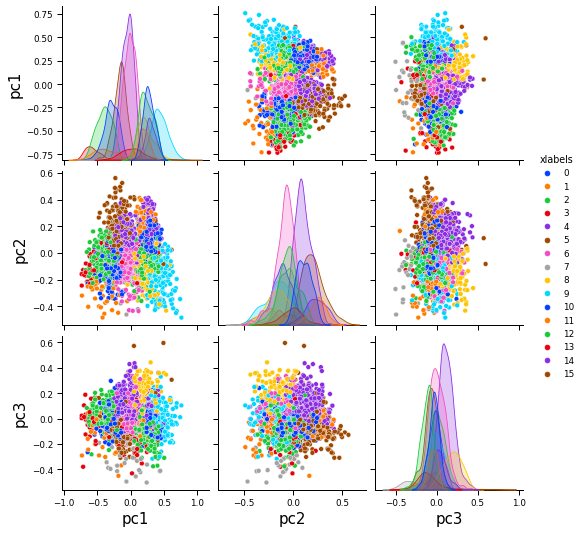

In [28]:
sns.set_context("paper", rc={"axes.labelsize":15, "legend":10})
plt.figure(figsize=(10,10))
sns.pairplot(data=principal3dDf1, hue="xlabels", palette="bright")
plt.show()

# Optics

In [13]:
optics = OPTICS(min_samples=4, max_eps=np.inf)
optics1 = OPTICS(min_samples=4, max_eps=np.inf)
optics.fit(X_minmax)
optics1.fit(X_minmax1)

OPTICS(min_samples=4)

In [14]:
silhouette_score(X_minmax[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.36981635042962585

In [15]:
np.unique(optics.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [16]:
silhouette_score(X_minmax1[optics1.labels_ != -1], optics1.labels_[optics1.labels_ != -1])

0.41949833974611916

In [17]:
np.unique(optics.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [18]:
df.head()

,length_ms,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_max,sc_mean,sc_std,sc_max,sc_kur,sc_skew,stft_std,stft_kur,stft_skew,mean,std,kur,skew,frame_count_fill
0,3737,16995,-33.485947,134.654860,171.69092,5792.550744,3328.055457,13541.959028,-1.120769,0.250940,0.335533,-1.215025,0.403514,3.844916e-07,0.014482,9.406061,0.273153,179379.0
1,3904,13906,-29.502108,130.485630,205.00770,5197.620555,4040.931570,12000.290443,-1.531204,0.219582,0.352380,-1.384174,0.290905,-7.149491e-08,0.020417,19.564187,0.292157,187387.0
2,4671,18723,-30.532463,126.577110,165.45653,4830.743037,3332.131300,12007.751173,-1.130153,0.436699,0.352270,-1.242947,0.470350,2.429985e-06,0.024317,4.881241,0.302659,224224.0
3,3637,11617,-36.059555,159.725160,190.03609,5376.446478,4053.663073,12048.223893,-1.497765,0.098802,0.360552,-1.445318,0.274756,2.373929e-07,0.003561,13.040259,-0.081014,174575.0
4,4404,15137,-31.405996,122.125824,161.13400,5146.012474,3442.724109,12025.582707,-1.167544,0.496066,0.350655,-1.366742,0.318926,8.454691e-07,0.027522,7.485109,0.414872,211411.0


<AxesSubplot:xlabel='zero_crossings_sum', ylabel='mfcc_mean'>

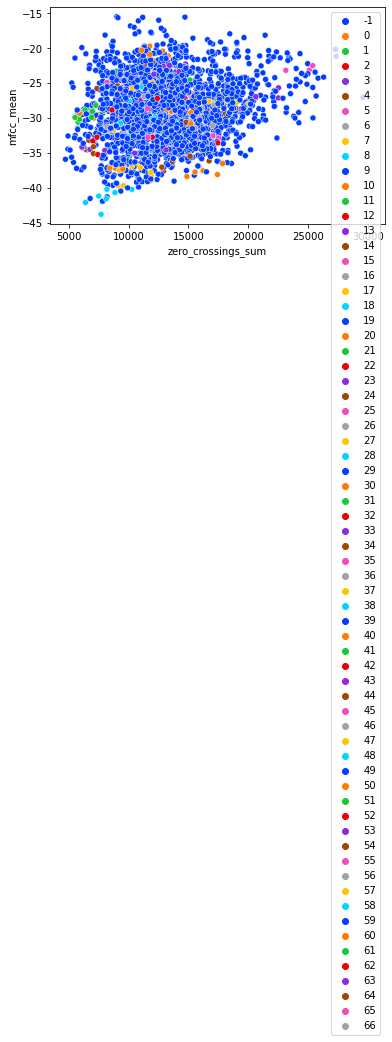

In [19]:
sns.scatterplot(data=df, x="zero_crossings_sum", y="mfcc_mean", hue=optics.labels_, palette="bright")